# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. 

Сначала мы подготовим данные: рассмотрим общую информацию о датафрейме и пропуски в нем. В исследовании задачи рассмотрим насколько сбалансированы классы, преобразуем категориальные признаки в численные с помощью техники прямого кодирования, затем обойдем дамми-ловушку, отмасштабируем признаки и попробуем обучить модель без баланса классов. 

В следующем блоке испробуем несколько способов балансировки классов и протестируем разные модели для того, чтобы добиться наилучшего значения F1-меры. Выберем лучшую модель и применим её к тестовой выборке.

## Подготовка данных

Подгрузим нужные инструменты и наш датасет.

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
import seaborn
import random
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
try:
    data = pd.read_csv('C:/Users/klimatutti/Downloads/Churn.csv')
except:
    data = pd.read_csv('/datasets/Churn.csv')

**Изучим первые строки датафрейма и общую информацию о нем**

In [3]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В одном столбце `Tenure` почти 1000 пропусков. Посмотрим, сколько % это составляет от всех строк.

In [5]:
(data.isna().sum() / len(data)).round(4) * 100

RowNumber          0.00
CustomerId         0.00
Surname            0.00
CreditScore        0.00
Geography          0.00
Gender             0.00
Age                0.00
Tenure             9.09
Balance            0.00
NumOfProducts      0.00
HasCrCard          0.00
IsActiveMember     0.00
EstimatedSalary    0.00
Exited             0.00
dtype: float64

10% пропусков. Рассмотрим, зависит ли данный столбец от других и примем решение о удалении или замене.

**`Tenure` - сколько лет человек является клиентом банка. Подробнее рассмотрим информацию об этом столбце**

In [6]:
data['Tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

В среднем 5 лет человек является клиентом банка

In [7]:
data.corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


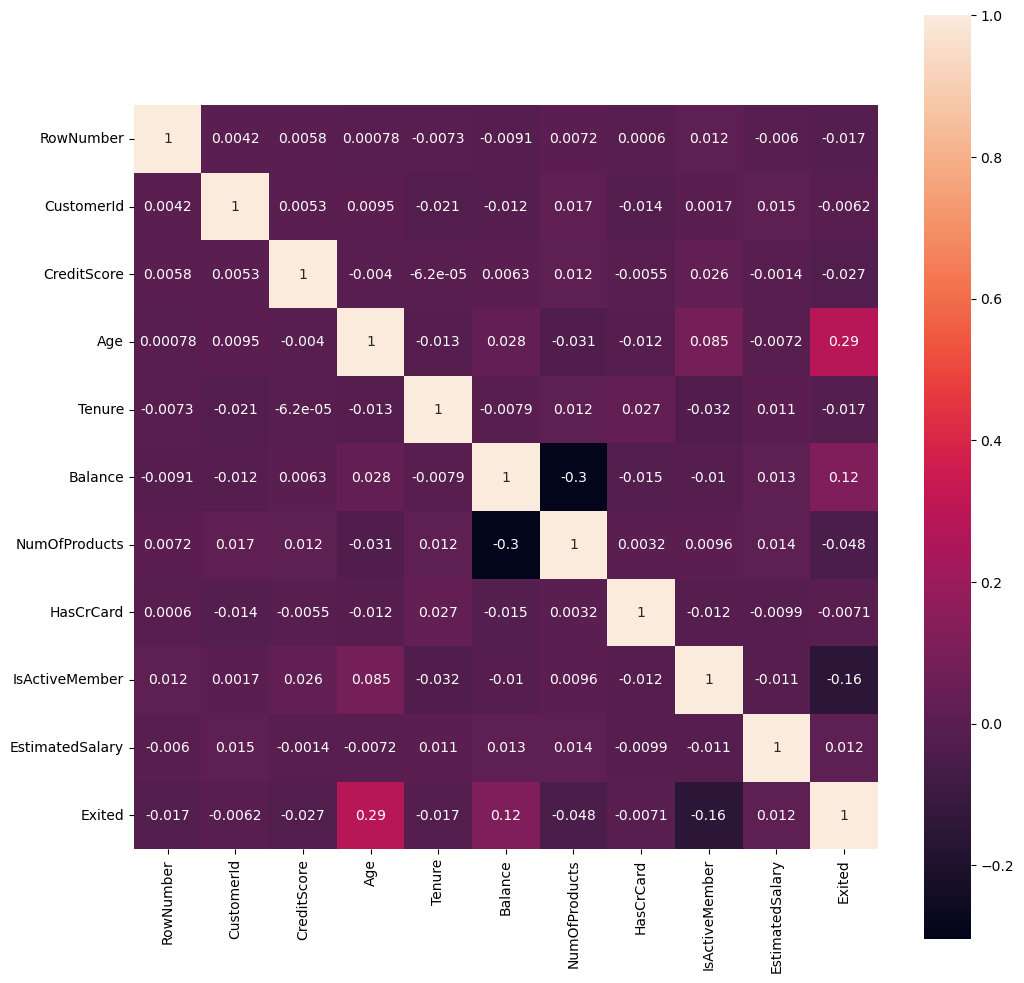

In [8]:
plt.figure(figsize=(12, 12))

seaborn.heatmap(data.corr(), annot=True, square=True);

Никаких зависимостей.

**Если пропуски заменить медианой или константой, распределение значений будет ненормированным. Из-за этого при обучении модели значение с большим выбросом будет считаться более важным. Попробуем удалить пропуски. Проследим за распределением.**.

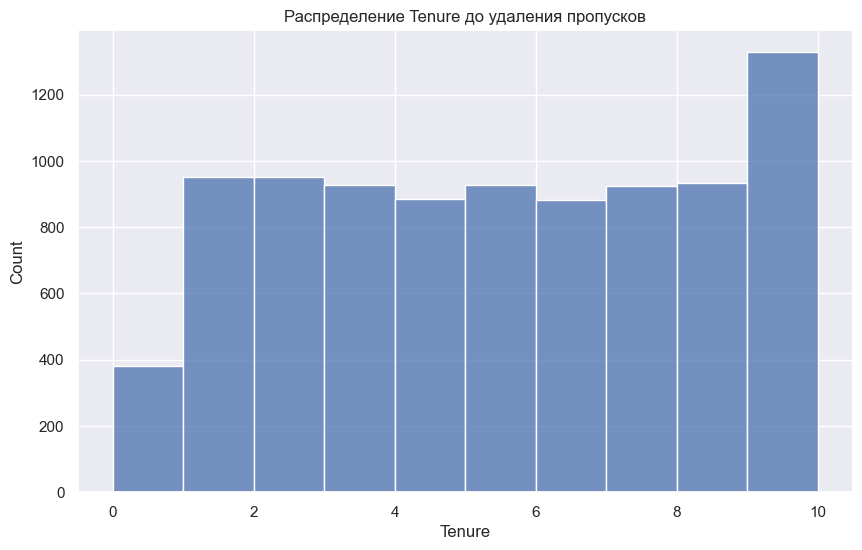

In [9]:
seaborn.set(rc = {'figure.figsize' : (10, 6)})
data_copy = data.copy()
seaborn.histplot(data_copy['Tenure'], bins = 10)
plt.title('Распределение Tenure до удаления пропусков');

In [10]:
data_copy = data_copy.dropna()

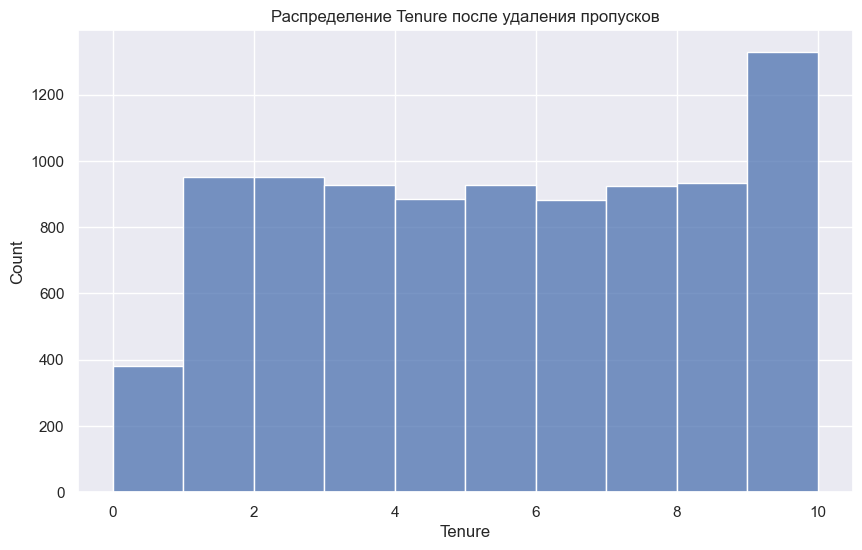

In [11]:
seaborn.histplot(data_copy['Tenure'], bins = 10)
plt.title('Распределение Tenure после удаления пропусков');

**Распределение значений до удаления пропусков и после практически не изменилось.**

Удалим пропуски в датасете.

In [12]:
data = data.dropna()

## Исследование задачи

Посмотрим, как распределены классы в нашем целевом признаке

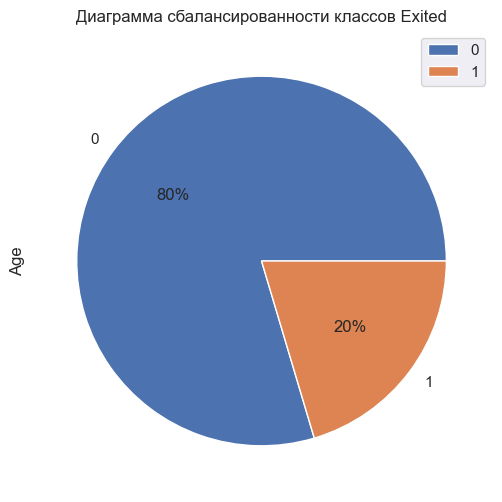

In [13]:
data.pivot_table(index='Exited', values='Age', aggfunc='count').plot(
    kind='pie', y='Age', autopct='%1.0f%%', title='Диаграмма сбалансированности классов Exited');

Классы определенно несбалансированы. 80% - 0 на 20% - 1...

Позже проверим, как работает модель с несбалансированными классами, а пока обработаем данные.

Разделим данные на признаки и целевой признак. Отметим, что такие столбцы, как `Surname`- фамилия, `RowNumber`-индекс строки в данных, `CustomerId'`-уникальный идентификатор клиента, никак не помогут в обучении модели, поэтому удалим их из признаков.

In [14]:
features = data.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
target = data['Exited']
features = pd.get_dummies(features, drop_first=True)

Далее разделим данные на три выборки: обучающую, валидационную и тестовую.

In [15]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.3, random_state=12345, stratify=target)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_test, target_test, test_size=0.5, random_state=12345, stratify=target_test)

Проверим, правильно ли разделились данные.

In [16]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)
print(features_valid.shape)
print(target_valid.shape)

(6363, 11)
(6363,)
(1364, 11)
(1364,)
(1364, 11)
(1364,)


Далее стандартизируем численные признаки.

In [17]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance',
           'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Изучим модель логистической регрессии на несбалансированной выборке.

In [20]:
algoritms = ['lbfgs', 'saga', 'sag', 'newton-cg', 'liblinear']
best_model_lr = None
best_result_f = 0
best_result_auc = 0
for a in algoritms:
    model = LogisticRegression(random_state=12345, solver=a, max_iter=100)
    model.fit(features_train, target_train)
    prediction_valid = model.predict(features_valid)
    result_f = f1_score(target_valid, prediction_valid)
    result_auc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
    if result_f > best_result_f:
        best_alg = a
        best_model_lr = model
        best_result_f = result_f
        best_result_auc = result_auc
print("F1-мера наилучшей модели на валидационной выборке:", best_result_f,
      'AUC-ROC-мера наилучшей модели на валидационной выборке', best_result_auc, "Лучший алгоритм:", best_alg)

F1-мера наилучшей модели на валидационной выборке: 0.3316062176165803 AUC-ROC-мера наилучшей модели на валидационной выборке 0.7788167256250248 Лучший алгоритм: lbfgs


Даже с подбором параметров метрика очень далека от единицы.

Посмотрим на матрицу ошибок.

In [21]:
print('Матрица ошибок для логистической регрессии', confusion_matrix(target_valid, prediction_valid))

Матрица ошибок для логистической регрессии [[1042   44]
 [ 214   64]]


Попробуем обучить модель решающего дерева.

In [22]:
best_model_ts= None
best_result_f = 0
best_result_auc = 0
for depth in range(1, 61):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, splitter='random')
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result_f = f1_score(target_valid, predictions_valid)
    result_auc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
    if result_f > best_result_f:
        best_model_ts = model
        best_depth = depth
        best_result_f = result_f
        best_result_auc = result_auc
                    
print("F1-мера", best_result_f, 'AUC-ROC', best_result_auc, "Глубина дерева:", best_depth)

F1-мера 0.5435244161358812 AUC-ROC 0.824347152112564 Глубина дерева: 6


F1-мера также далека от значения, которое нам нужно, но уже лучше предыдущей модели.

In [23]:
print('Матрица ошибок для решающего дерева', confusion_matrix(target_valid, predictions_valid))

Матрица ошибок для решающего дерева [[916 170]
 [142 136]]


Модель часто видит отрицательные ответы там, где их нет.

Обучим модель случайного леса на несбалансированной выборке.

In [24]:
best_model_rt = None
best_result_f = 0
best_result_auc = 0
for est in range(10, 31, 10):
    for depth in range (1, 61):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result_f = f1_score(target_valid, predictions_valid)
        result_auc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
        if result_f > best_result_f:
            best_model_rt = model
            best_depth = depth
            best_est = est
            best_result_f = result_f
            best_result_auc = result_auc           
print('F1-мера', best_result_f, 'AUC-ROC', best_result_auc, "Количество деревьев:", best_est, "Глубина:", best_depth)

F1-мера 0.5982905982905983 AUC-ROC 0.8562409740715715 Количество деревьев: 30 Глубина: 16


А у случайного леса метрика достигла того, что нам нужно.

In [25]:
print('Матрица ошибок для случайного леса', confusion_matrix(target_valid, predictions_valid))

Матрица ошибок для случайного леса [[1043   43]
 [ 146  132]]


Но это говорит о том, что при сбалансированной выборке результат будет еще лучше.

## Борьба с дисбалансом

**Применим первый метод борьбы с дисбалансом - аргумент `class_weight='balanced'`**

Первая модель - логистическая регрессия. 

С помощью цикла сразу выявим лучший алгоритм логистической регрессии.

In [26]:
algoritms = ['lbfgs', 'saga', 'sag', 'newton-cg', 'liblinear']
best_model_lr = None
best_result_f = 0
best_result_auc = 0
for a in algoritms:
    model = LogisticRegression(random_state=12345, solver=a, max_iter=100, class_weight='balanced')
    model.fit(features_train, target_train)
    prediction_valid = model.predict(features_valid)
    result_f = f1_score(target_valid, prediction_valid)
    result_auc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
    if result_f > best_result_f:
        best_alg = a
        best_model_lr = model
        best_result_f = result_f
        best_result_auc = result_auc
print("F1-мера наилучшей модели на валидационной выборке:", best_result_f,
      'AUC-ROC-мера наилучшей модели на валидационной выборке', best_result_auc, "Лучший алгоритм:", best_alg)

F1-мера наилучшей модели на валидационной выборке: 0.5061728395061728 AUC-ROC-мера наилучшей модели на валидационной выборке 0.7803734912622388 Лучший алгоритм: lbfgs


При обучении модели с несбалансированными выборками результат логистической регрессии был 0.33.

Результат стал намного лучше, но ддо нужного значения все же не дотягивает, рассмотрим другие модели.

Рассмотрим вторую модель с таким методом балансировки - случайный лес.

В цикле найдем лучшие количество деревьев и глубину.

In [27]:
best_model_rt = None
best_result_f = 0
best_result_auc = 0
for est in range(10, 31, 10):
    for depth in range (1, 61):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result_f = f1_score(target_valid, predictions_valid)
        result_auc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
        if result_f > best_result_f:
            best_model_rt = model
            best_depth = depth
            best_est = est
            best_result_f = result_f
            best_result_auc = result_auc           
print('F1-мера', best_result_f, 'AUC-ROC', best_result_auc, "Количество деревьев:", best_est, "Глубина:", best_depth)

F1-мера 0.6148648648648649 AUC-ROC 0.8624481630165481 Количество деревьев: 30 Глубина: 9


С первым же методом балансировки достигли нужной отметки.

Последняя модель - решающее дерево. Также найдем лучшую глубину.

In [28]:
best_model_ts= None
best_result_f = 0
best_result_auc = 0
for depth in range(1, 61):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced', splitter='random')
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result_f = f1_score(target_valid, predictions_valid)
    result_auc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
    if result_f > best_result_f:
        best_model_ts = model
        best_depth = depth
        best_result_f = result_f
        best_result_auc = result_auc
                    
print("F1-мера", best_result_f, 'AUC-ROC', best_result_auc, "Глубина дерева:", best_depth)

F1-мера 0.5718270571827058 AUC-ROC 0.8252116538813148 Глубина дерева: 8


Хуже предыдущей модели и нужной отметки не достигли.

**Слудеющий метод балансировки - увеличение выборки**

- Разделим обучающую выборку на отрицательные и положительные объекты;
- Скопируем несколько раз положительные объекты;
- С учётом полученных данных создадим новую обучающую выборку;
- Перемешаем данные.
- Обучим модели.

In [37]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)


Для получения лучших результатов применим параметры, отобранные ранее.

**Логистическая регрессия**

In [38]:
model_lr_up = LogisticRegression(random_state=12345, solver='lbfgs')
model_lr_up.fit(features_upsampled, target_upsampled)
predicted_valid = model_lr_up.predict(features_valid)
print("F1-мера логистической регрессии после увеличения выборки", f1_score(target_valid, predicted_valid),
     'AUC_ROC', roc_auc_score(target_valid, model_lr_up.predict_proba(features_valid)[:, 1]))

F1-мера логистической регрессии после увеличения выборки 0.41712926249008725 AUC_ROC 0.7804297998065635


Результат лучше, чем при несбалансированных выборках, но хуже, чем при предыдущем методе балансировки.

**Случайный лес**

In [39]:
model_rf_up = RandomForestClassifier(random_state=12345, n_estimators=30, max_depth=53)
model_rf_up.fit(features_upsampled, target_upsampled)
predicted_valid = model_rf_up.predict(features_valid)
print("F1-мера случайного леса после увеличения выборки", f1_score(target_valid, predicted_valid),
     'AUC_ROC', roc_auc_score(target_valid, model_rf_up.predict_proba(features_valid)[:, 1]))

F1-мера случайного леса после увеличения выборки 0.5831702544031311 AUC_ROC 0.8383563867138334


Результат также хуже, чем с другим методом балансировки. Проверим последнюю модель.

**Решающее дерево**

In [40]:
model_dt_up = DecisionTreeClassifier(random_state=12345, max_depth=51)
model_dt_up.fit(features_upsampled, target_upsampled)
predicted_valid = model_dt_up.predict(features_valid)
print("F1-мера решающего дерева после увеличения выборки", f1_score(target_valid, predicted_valid),
     'AUC_ROC', roc_auc_score(target_valid, model_dt_up.predict_proba(features_valid)[:, 1]))

F1-мера решающего дерева после увеличения выборки 0.5008635578583764 AUC_ROC 0.6889681624865852


Отбрасываем данный способ балансировки.

Следующий способ - **уменьшение выборки**

- Разделим обучающую выборку на отрицательные и положительные объекты;
- Случайным образом отбросим часть из отрицательных объектов;
- С учётом полученных данных создадим новую обучающую выборку;
- Перемешаем данные;
- Обучим модели.

In [41]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)


**Логистическая регрессия**

In [42]:
model_lr_down = LogisticRegression(random_state=12345, solver='lbfgs')
model_lr_down.fit(features_downsampled, target_downsampled)
predicted_valid = model_lr_down.predict(features_valid)

print("F1-мера логистической регрессии после уменьшения выборки", f1_score(target_valid, predicted_valid),
     'AUC_ROC', roc_auc_score(target_valid, model_lr_down.predict_proba(features_valid)[:, 1]))

F1-мера логистической регрессии после уменьшения выборки 0.4154209284028324 AUC_ROC 0.7793963724048385


Результат такой же.

**Случайный лес**

In [43]:
model_rf_down = RandomForestClassifier(random_state=12345, n_estimators=30, max_depth=53)
model_rf_down.fit(features_upsampled, target_upsampled)
predicted_valid = model_rf_down.predict(features_valid)
print("F1-мера случайного леса после увеличения выборки", f1_score(target_valid, predicted_valid),
     'AUC_ROC', roc_auc_score(target_valid, model_rf_down.predict_proba(features_valid)[:, 1]))

F1-мера случайного леса после увеличения выборки 0.5831702544031311 AUC_ROC 0.8383563867138334


Аналогично.

**Дерево решений**

In [44]:
model_dt_down = DecisionTreeClassifier(random_state=12345, max_depth=51)
model_dt_down.fit(features_upsampled, target_upsampled)
predicted_valid = model_dt_down.predict(features_valid)
print("F1-мера решающего дерева после увеличения выборки", f1_score(target_valid, predicted_valid),
     'AUC_ROC', roc_auc_score(target_valid, model_dt_down.predict_proba(features_valid)[:, 1]))

F1-мера решающего дерева после увеличения выборки 0.5008635578583764 AUC_ROC 0.6889681624865852


Результаты при увеличении и уменьшении выборки показали практически одинаковые результаты.

Последний метод балансировки - **изменение порога классификации**

Переберем значения порогов от 0 до 0.3 с шагом 0.02. Найдем для каждого значения точность, полноту и F1-меру.

In [46]:
model = LogisticRegression(random_state=12345, solver='lbfgs')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.3, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    auc = roc_auc_score(target_valid, probabilities_one_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}, AUC-ROC = {:.3f}".format(
        threshold, precision, recall, f1, auc))

Порог = 0.00 | Точность = 0.204, Полнота = 1.000, F1 = 0.339, AUC-ROC = 0.779
Порог = 0.02 | Точность = 0.204, Полнота = 0.996, F1 = 0.339, AUC-ROC = 0.779
Порог = 0.04 | Точность = 0.214, Полнота = 0.989, F1 = 0.352, AUC-ROC = 0.779
Порог = 0.06 | Точность = 0.231, Полнота = 0.975, F1 = 0.374, AUC-ROC = 0.779
Порог = 0.08 | Точность = 0.254, Полнота = 0.968, F1 = 0.402, AUC-ROC = 0.779
Порог = 0.10 | Точность = 0.270, Полнота = 0.924, F1 = 0.418, AUC-ROC = 0.779
Порог = 0.12 | Точность = 0.287, Полнота = 0.896, F1 = 0.434, AUC-ROC = 0.779
Порог = 0.14 | Точность = 0.311, Полнота = 0.874, F1 = 0.458, AUC-ROC = 0.779
Порог = 0.16 | Точность = 0.337, Полнота = 0.827, F1 = 0.479, AUC-ROC = 0.779
Порог = 0.18 | Точность = 0.354, Полнота = 0.784, F1 = 0.488, AUC-ROC = 0.779
Порог = 0.20 | Точность = 0.368, Полнота = 0.727, F1 = 0.489, AUC-ROC = 0.779
Порог = 0.22 | Точность = 0.400, Полнота = 0.701, F1 = 0.509, AUC-ROC = 0.779
Порог = 0.24 | Точность = 0.405, Полнота = 0.640, F1 = 0.497, AU

Модель логистической регресси с таким методом балансировки показала наилучший результат F1-меры = 0.509 и AUC-ROC = 0.779 с порогом 0.22, но до нужного значения так и не дотягивает.

Построим для модели ROC-кривую

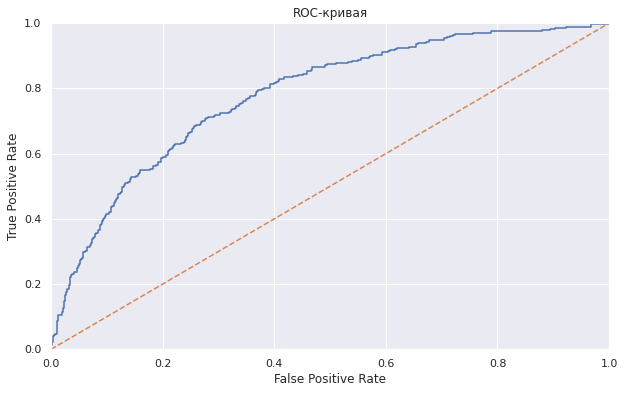

In [69]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0,1)
plt.ylim(0,1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')

plt.show()

**Мы перебрали несколько способов балансировки, параметры моделей и выяснили, что лучшей моделью является Случайный лес с методом балансировки class_weight. Результат модели: F1-мера 0.615 AUC-ROC 0.862 Количество деревьев: 30 Глубина: 9**

## Тестирование модели

Соединим тестовую и валидационную выборки и заново обучим модель.

In [49]:
best_result_f = 0
best_result_auc = 0
features_test_valid = pd.concat([features_test, features_valid], ignore_index=True, axis=0)
target_test_valid = pd.concat([target_test, target_valid], ignore_index=True, axis=0)

for est in range(10, 31, 10):
    for depth in range (1, 61):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_test_valid)
        result_f = f1_score(target_test_valid, predictions_valid)
        result_auc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
        if result_f > best_result_f:
            best_depth = depth
            best_est = est
            best_result_f = result_f
            best_result_auc = result_auc
print('F1-мера', best_result_f, 'AUC-ROC', best_result_auc, "Количество деревьев:", best_est, "Глубина:", best_depth)

F1-мера 0.6201550387596899 AUC-ROC 0.8624481630165481 Количество деревьев: 30 Глубина: 9


### Таким образом, с помощью модели случайного леса мы добились значения F1-меры 0.62 и AUC-ROC 0.86

## Вывод

Перед нами стояла задача построить модель, которая должна спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

Необходимо было построить модель с предельно большим значением F1-меры и довести её до 0.59.

Нами были рассмотрены следующие модели:

- Логистическая регрессия;
- Дерево решений;
- Случайный лес.

В каждой из моделей были отобраны параметры, которые в совокупность составляли лучшую модель.

Далее с отобранными параметрами были протестированы методы борьбы с дисбалансом классов в выборке. Рассматривались следующие методы:

- Параметр class_weight='balanced';
- Увеличение выборки;
- Уменьшение выборки;
- Изменение порога.

Перебрав большое количество параметров и методов, была найдена лучшая модель.

Ею оказалась модель **Случайного леса** с методом балансировки с помощью параметра.

Результат модели случайного леса на валидационной выборке: **F1-мера 0.6148648648648649, AUC-ROC 0.8624481630165481**

В финальной части проекта данная модель была применена к сложенным тестовой и валидационной выборкам.

Результат лучшей модели на суммарных выборках: **F1-мера 0.6201550387596899, AUC-ROC 0.8624481630165481**